In [2]:
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install seaborn


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


  Using cached matplotlib-3.10.3-cp313-cp313-win_amd64.whl.metadata (11 kB)
  Using cached contourpy-1.3.2-cp313-cp313-win_amd64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached kiwisolver-1.4.8-cp313-cp313-win_amd64.whl.metadata (6.3 kB)
  Using cached pillow-11.2.1-cp313-cp313-win_amd64.whl.metadata (9.1 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
Using cached matplotlib-3.10.3-cp313-cp313-win_amd64.whl (8.1 MB)
Using cached contourpy-1.3.2-cp313-cp313-win_amd64.whl (223 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   ---- ----------------------------------- 0.3/2.2 MB ? eta -:--:--
   --------- ------------------------------ 0.5/2.2 MB 1.1 MB/s eta 0:00:02
   -------------- ------------------------- 0.8/2.2 MB 1.0 MB/s eta 0:00:02
   ------------------ --------------------- 1.0/2.2 MB 1.1 MB/s eta 0:00:02
   ------------------


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [4]:
agency = pd.read_csv('C:/Users/HP/PyCharmMiscProject/agency.txt')
calendar = pd.read_csv('C:/Users/HP/PyCharmMiscProject/calendar.txt')
routes = pd.read_csv('C:/Users/HP/PyCharmMiscProject/routes.txt')
shapes = pd.read_csv('C:/Users/HP/PyCharmMiscProject/shapes.txt')
stops = pd.read_csv('C:/Users/HP/PyCharmMiscProject/stops.txt')
trips = pd.read_csv('C:/Users/HP/PyCharmMiscProject/trips.txt')
stop_times = pd.read_csv('C:/Users/HP/PyCharmMiscProject/stop_times.txt')

Extract relevant info. about the dataset

In [5]:
agency_name = agency.loc[0, 'agency_name']
start_date = calendar['start_date'].min()
end_date = calendar['end_date'].max()
print("Agency Name:", agency_name)
print("Start Date:", start_date)
print("End Date:", end_date)

Agency Name: Delhi Metro Rail Corporation
Start Date: 20190101
End Date: 20251231


Service Frequency by Day of Week

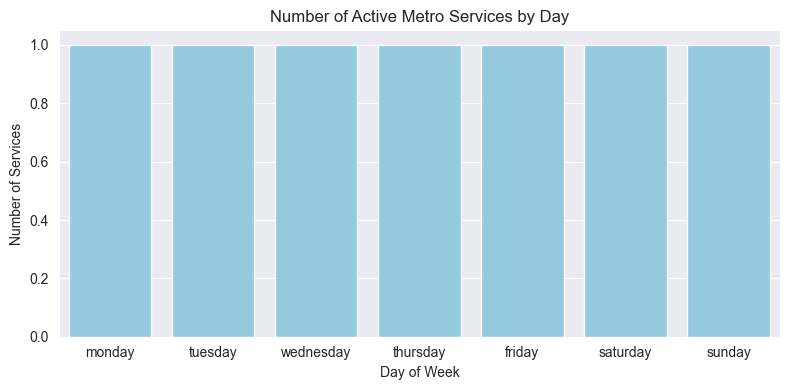

In [15]:
days = ['monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday']
service_freq = calendar[days].sum()
plt.figure(figsize=(8, 4))
sns.barplot(x=service_freq.index, y=service_freq.values, color='skyblue')

plt.title('Number of Active Metro Services by Day')
plt.ylabel('Number of Services')
plt.xlabel('Day of Week')
plt.tight_layout()
plt.show()

Number of Trips per Route (Top 10)

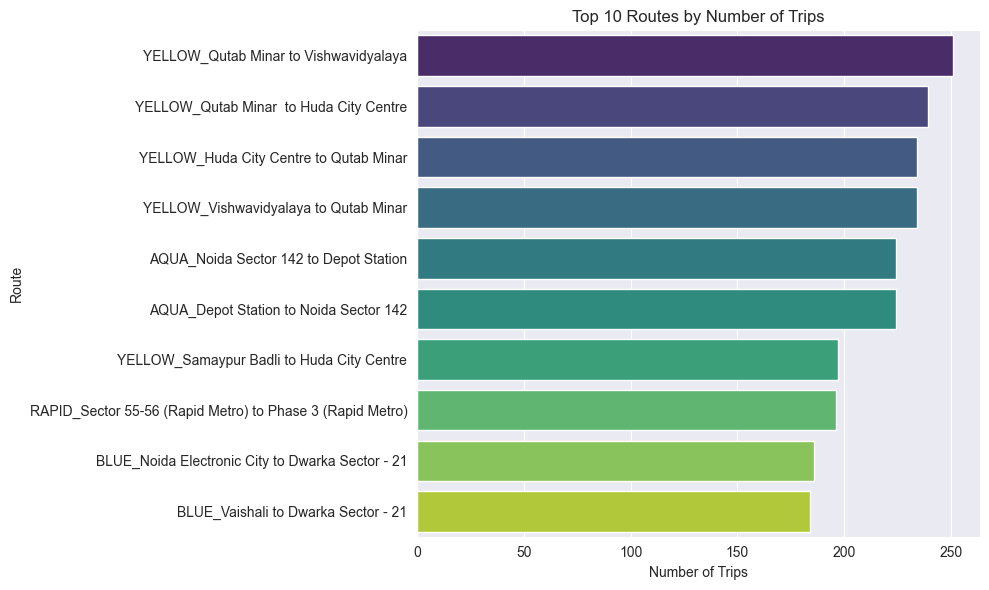

In [17]:
trips_route = trips['route_id'].value_counts().head(10).reset_index()
trips_route.columns = ['route_id', 'num_trips']
route_names = routes.set_index('route_id')['route_long_name'].to_dict()
trips_route['route_name'] = trips_route['route_id'].map(route_names)
plt.figure(figsize=(10,6))
sns.barplot(y='route_name', x='num_trips', data=trips_route,  hue='route_name', palette='viridis')
plt.title('Top 10 Routes by Number of Trips')
plt.xlabel('Number of Trips')
plt.ylabel('Route')
plt.tight_layout()
plt.show()

Spatial Distribution of Metro Stations with Heatmap colouring of stations

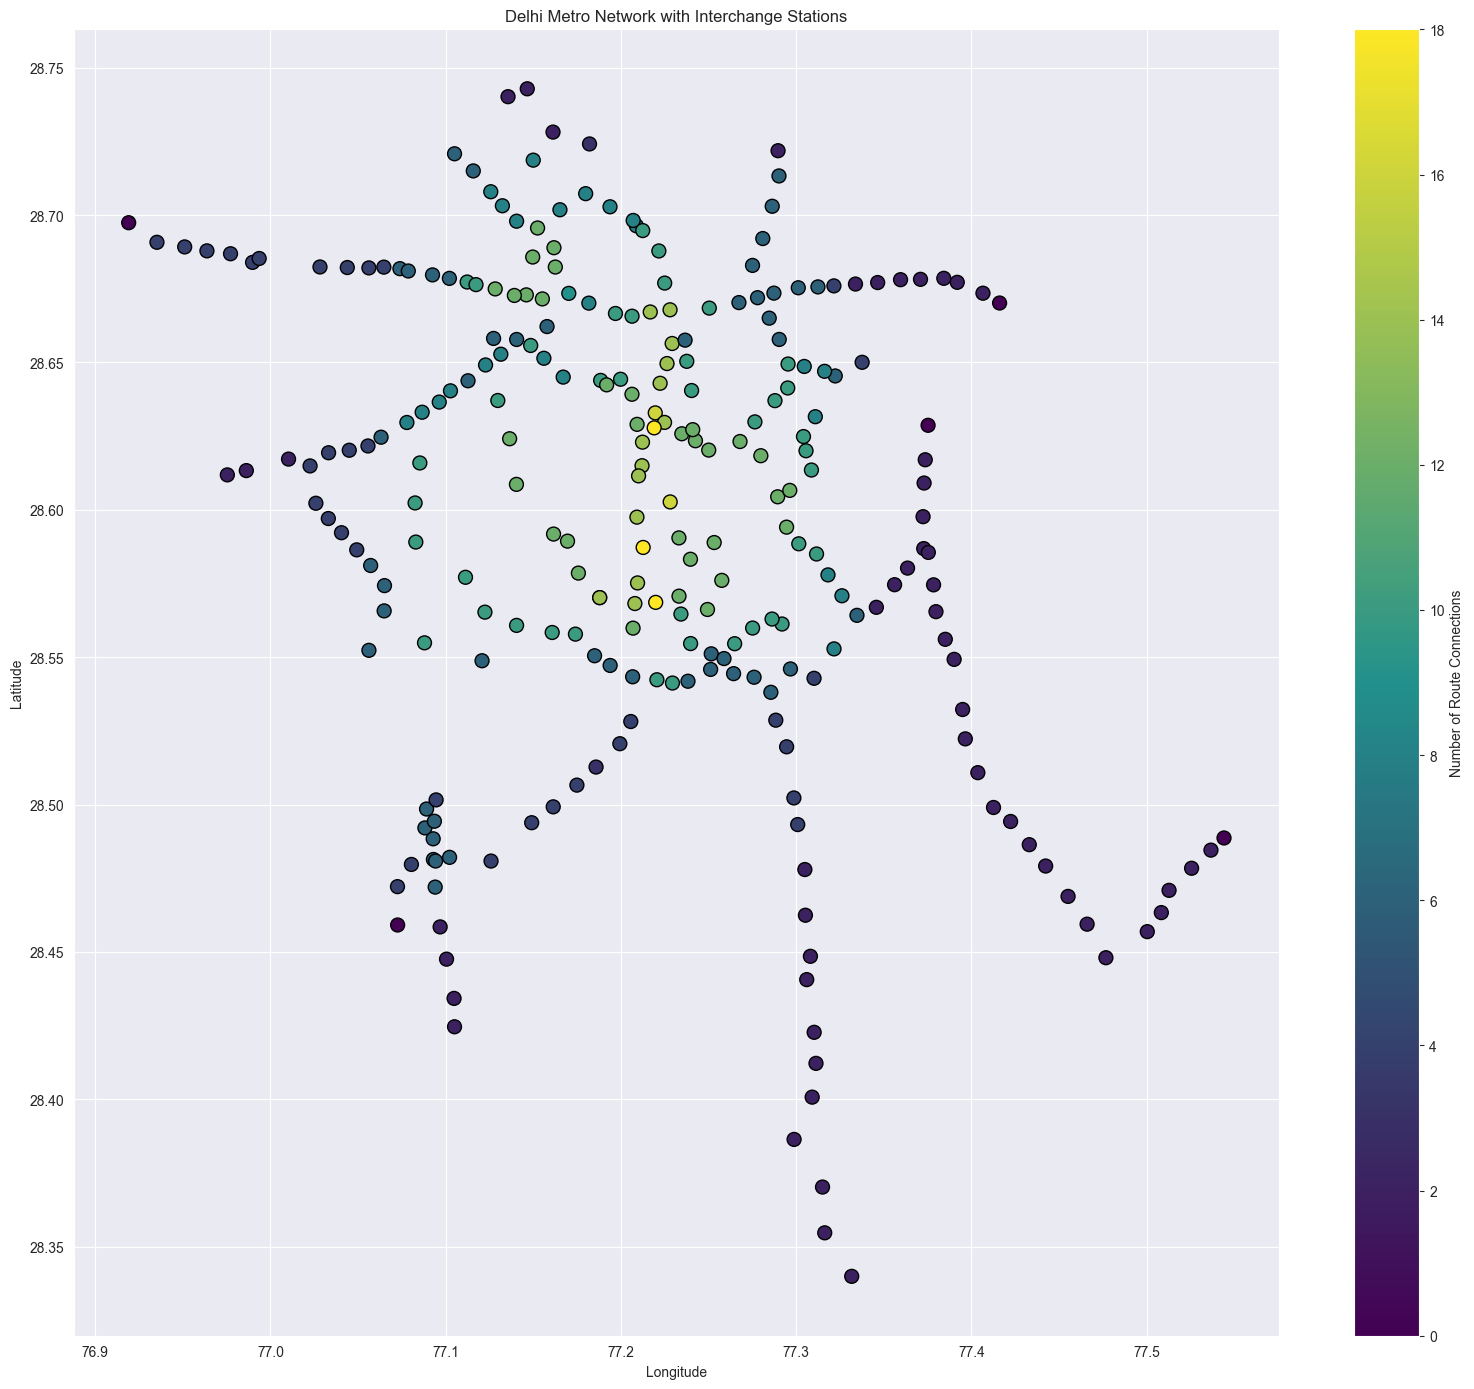

In [35]:
from matplotlib.colors import LinearSegmentedColormap

# Route's color mapping
route_colors = {
    'R_RD': '#FF0000',    # Red Line
    'Y_HS': '#FFFF00',    # Yellow Line
    'B_DN': '#0000FF',    # Blue Line
    'G_KB': '#008000',    # Green Line
    'V_KB': '#800080',    # Violet Line
    'M_JB': '#FF00FF',    # Magenta Line
    'P_MS': '#FFC0CB',    # Pink Line
    'A_NN': '#00FFFF',    # Aqua Line
    'G_DD': '#A9A9A9',    # Gray Line
    'R_SP': '#FFA500'     # Rapid Metro
}

plt.figure(figsize=(16, 14))

# Routes with distinct colors
for route_id, group in trips.groupby('route_id'):
    if route_id in route_colors:
        color = route_colors[route_id]
        # Get first shape for this route
        shape_id = group['shape_id'].iloc[0]
        route_shapes = shapes[shapes['shape_id'] == shape_id]
        route_shapes = route_shapes.sort_values('shape_pt_sequence')
        plt.plot(route_shapes['shape_pt_lon'], route_shapes['shape_pt_lat'],
                 color=color, linewidth=2, alpha=1, label=route_id)

# Identifying interchange stations
route_stops = {}
for route_id, group in trips.groupby('route_id'):
    # Get unique stops for this route (simplified)
    route_shapes = shapes[shapes['shape_id'].isin(group['shape_id'])]
    # Find nearest stops to route path
    route_stops[route_id] = stops[
        (stops['stop_lon'].between(route_shapes['shape_pt_lon'].min(), route_shapes['shape_pt_lon'].max())) &
        (stops['stop_lat'].between(route_shapes['shape_pt_lat'].min(), route_shapes['shape_pt_lat'].max()))
    ]['stop_id'].tolist()

# Route connections per station
station_connections = {}
for stop_id in stops['stop_id']:
    count = 0
    for route, stop_list in route_stops.items():
        if stop_id in stop_list:
            count += 1
    station_connections[stop_id] = count
stops['connections'] = stops['stop_id'].map(station_connections)

# Plot stations with heatmap coloring
cmap = LinearSegmentedColormap.from_list('interchange', ['#440154', '#21918c', '#fde725'])
plt.scatter(stops['stop_lon'], stops['stop_lat'],
            c=stops['connections'],
            cmap=cmap, s=100,
            edgecolor='black', alpha=1)

cbar = plt.colorbar()
cbar.set_label('Number of Route Connections')

plt.title('Delhi Metro Network with Interchange Stations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(alpha=1)
plt.tight_layout()
plt.show()

Histogram of Station Latitudes and longitudes (to show N-S and E-W spread respectively)

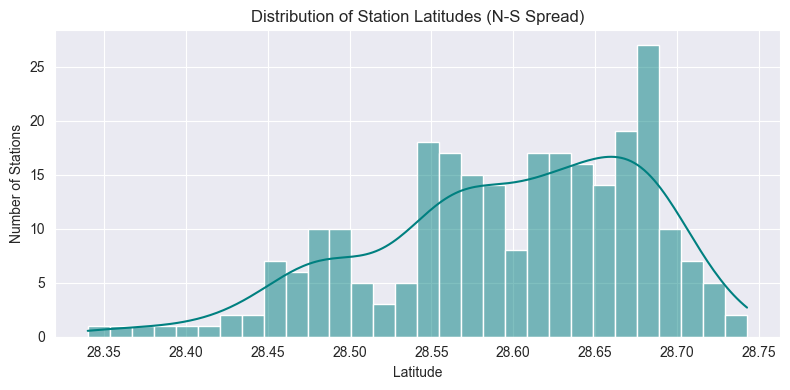

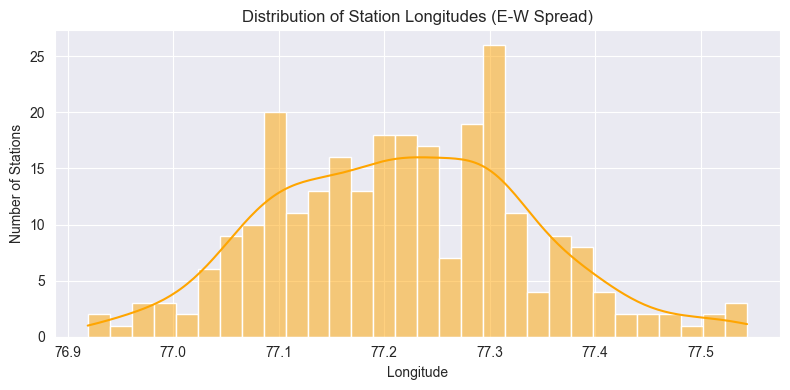

In [37]:
plt.figure(figsize=(8,4))
sns.histplot(stops['stop_lat'], bins=30, kde=True, color='teal')
plt.title('Distribution of Station Latitudes (N-S Spread)')
plt.xlabel('Latitude')
plt.ylabel('Number of Stations')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,4))
sns.histplot(stops['stop_lon'], bins=30, kde=True, color='orange')
plt.title('Distribution of Station Longitudes (E-W Spread)')
plt.xlabel('Longitude')
plt.ylabel('Number of Stations')
plt.tight_layout()
plt.show()

Frequency of trip durations

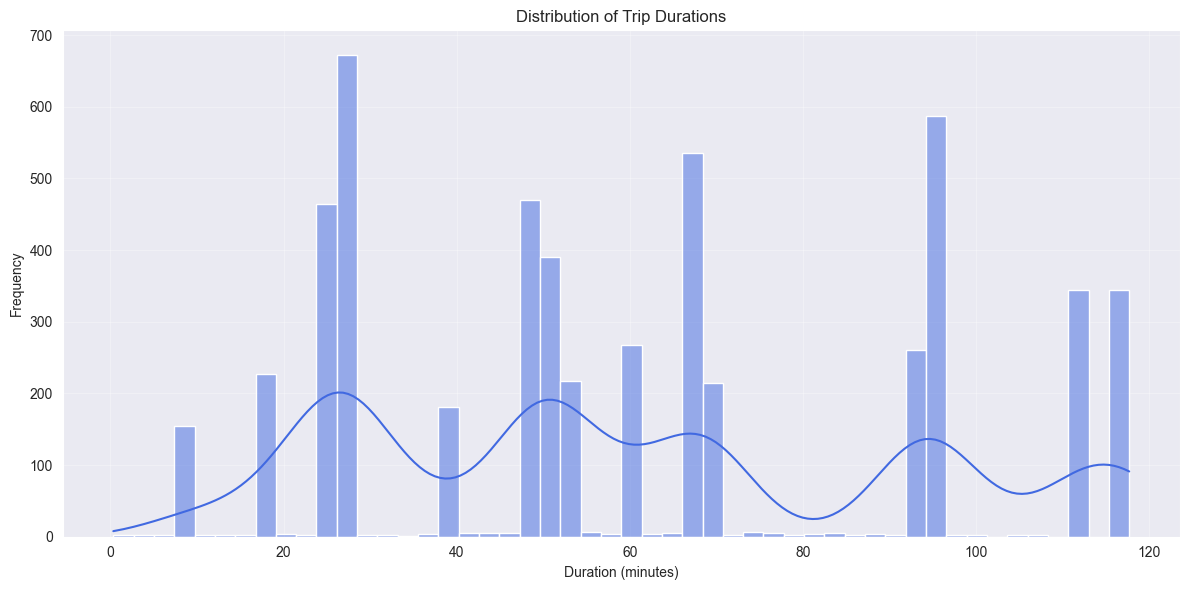

In [58]:
stop_times['arrival_time'] = pd.to_datetime(stop_times['arrival_time'], format='%H:%M:%S', errors='coerce')
stop_times['departure_time'] = pd.to_datetime(stop_times['departure_time'], format='%H:%M:%S', errors='coerce')

trip_durations = stop_times.groupby('trip_id')[['arrival_time','departure_time']].apply(
    lambda x: (x['departure_time'].max() - x['arrival_time'].min()).total_seconds() / 60
).reset_index(name='duration_min')

plt.figure(figsize=(12, 6))
sns.histplot(trip_durations['duration_min'], bins=50, kde=True, color='royalblue')
plt.title('Distribution of Trip Durations')
plt.xlabel('Duration (minutes)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Delhi Metro User Density Heatmap

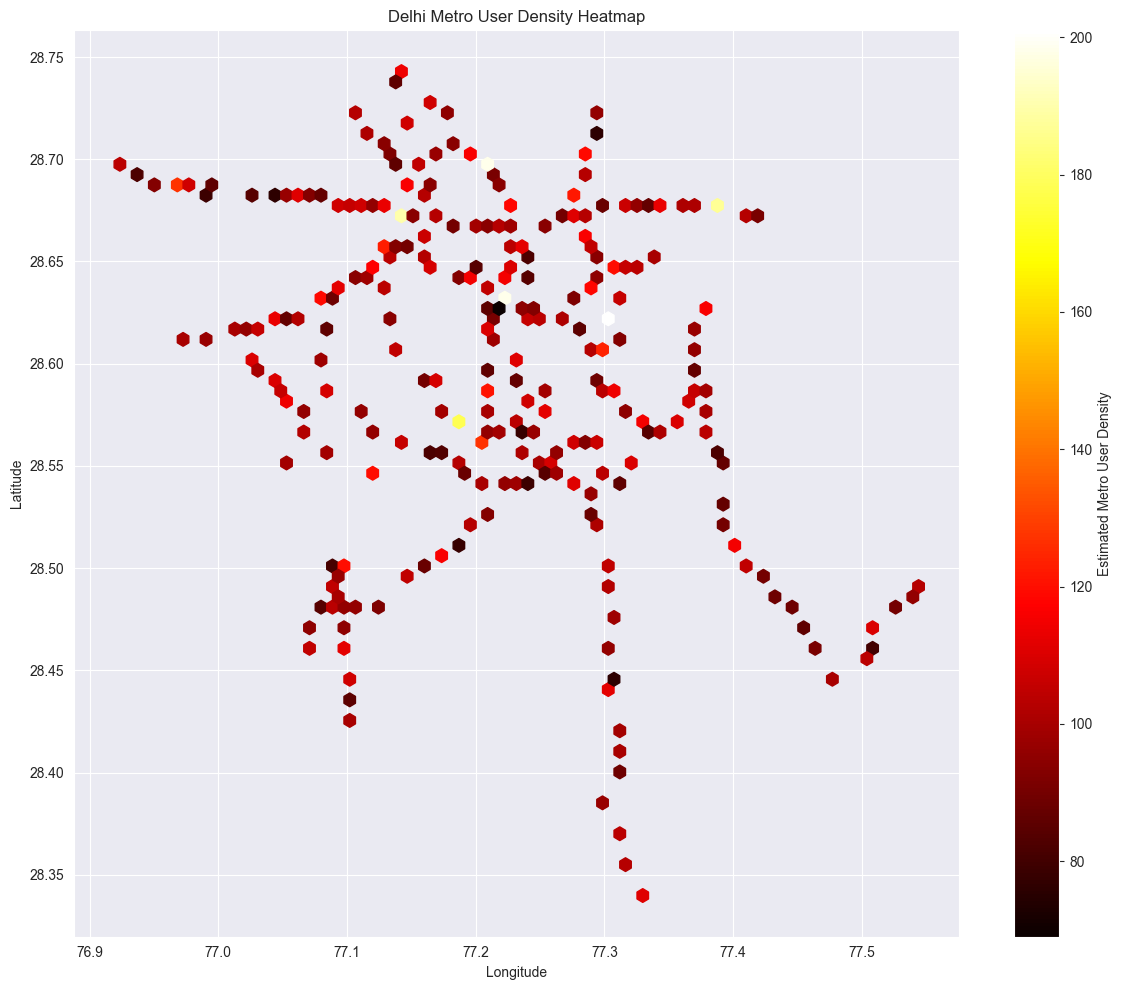

In [60]:
np.random.seed(42)
stops['user_count'] = np.random.poisson(lam=100, size=len(stops))

plt.figure(figsize=(12, 10))
plt.hexbin(
    stops['stop_lon'], stops['stop_lat'],
    C=stops['user_count'],
    gridsize=70,
    reduce_C_function=np.sum,
    cmap='hot',   # red-yellow-white
    mincnt=1
)

plt.colorbar(label='Estimated Metro User Density')
plt.title('Delhi Metro User Density Heatmap')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()
plt.show()